Pytorch install

In [1]:
!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████▊                | 1002.8 MB 13.1 MB/s eta 0:01:20    |███                             | 194.9 MB 98.2 MB/s eta 0:00:19     |██████████████▊                 | 940.0 MB 125.9 MB/s eta 0:00:09     |███████████████▌                | 987.3 MB 13.1 MB/s eta 0:01:21

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████▊           | 1323.0 MB 121.3 MB/s eta 0:00:06

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |█████████████████████████▋      | 1631.2 MB 79.7 MB/s eta 0:00:06

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████▍   | 1808.0 MB 86.3 MB/s eta 0:00:03     |██████████████████████████████▌ | 1944.4 MB 118.0 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 2040.6 MB 66.8 MB/s eta 0:00:01     |████████████████████████████████| 2041.3 MB 6.1 kB/s  eta 0:00:01
     |████████████████████████████████| 23.2 MB 49.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 9.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install nuscenes-devkit

     |████████████████████████████████| 283 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 51.0 MB 31.2 MB/s eta 0:00:01
     |████████████████████████████████| 87 kB 7.4 MB/s  eta 0:00:01
     |████████████████████████████████| 22.2 MB 39.9 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 67.0 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 66.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 67.4 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 10.2 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 75.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 74.2 MB/s eta 0:00:01
  Using cached Cython-0.29.23-cp36-cp36m-manylinux1_x86_64.whl (2.0 MB)
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=002a4a2830b62434d536b08683872f28ee5565c276d321a753dc564259df7ee6
  Stored in directory: /root/.cache/pip/wheels/a6/12/74/ce0728e3990845862240349a12d717

In [10]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 170 kB 75.4 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 15.0 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 93.2 MB/s eta 0:00:01
     |████████████████████████████████| 291 kB 74.6 MB/s eta 0:00:01
     |████████████████████████████████| 640 kB 89.8 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 12.4 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 3.6 MB/s  eta 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21494 sha256=39b9b50ba8ae3512464c637180e3f1b757bd80db9b478b1dabf7887e69acd47f
  Stored in directory: /root/.cache/pip/wheels/59/9a/1d/3f1afbbb5122d0410547bf9eb50955f4a7a98e53a6d8b99bd1
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8784 sha256=be4fc574a7461712756e96b658e6c7e7b5d15

In [4]:
# Fix error : libGL.so.1: cannot open shared object file: No such file or directory
!apt-get update
!apt install -y libgl1-mesa-glx

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [2657 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.download

In [3]:
import torch

print(torch.cuda.is_available())

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on ', device)
print(f"Device count: {torch.cuda.device_count()}")

True
Running on  cuda:0
Device count: 1


In [5]:
#CURRENT_PATH = './NpyDataset/'
CURRENT_PATH = './'

In [6]:
import os
import zipfile
import subprocess

def unzipFile(pathToZip, pathToOut):
    unzip = ['unzip', '-o', pathToZip, '-d', pathToOut]
    p = subprocess.call(unzip)

unzipFile(f'./prediction_trajectory_sets.zip', CURRENT_PATH)
unzipFile(f'./repVgg.zip', CURRENT_PATH)

In [14]:
unzipFile(f'./multiagent_train_features_5k.zip', CURRENT_PATH)
unzipFile(f'./multiagent_validation_features_2k.zip', CURRENT_PATH)

In [23]:
# unzipFile(f'./multiagent_test_features_2k.zip', CURRENT_PATH)

In [15]:
import numpy as np

# Npy dataset

train_features = np.load(f'{CURRENT_PATH}multiagent_train_features_5k.npy')
train_states = np.load(f'{CURRENT_PATH}multiagent_train_states_5k.npy')
train_labels = np.load(f'{CURRENT_PATH}multiagent_train_labels_5k.npy')

validation_features = np.load(f'{CURRENT_PATH}multiagent_validation_features_2k.npy')
validation_states = np.load(f'{CURRENT_PATH}multiagent_validation_states_2k.npy')
validation_labels = np.load(f'{CURRENT_PATH}multiagent_validation_labels_2k.npy')

In [4]:
# test_features = np.load(f'{CURRENT_PATH}multiagent_test_features_2k.npy')
# test_states = np.load(f'{CURRENT_PATH}multiagent_test_states_2k.npy')
# test_labels = np.load(f'{CURRENT_PATH}multiagent_test_labels_2k.npy')

In [16]:
len(train_features), len(train_states), len(train_labels), len(validation_features), len(validation_states), len(validation_labels)

(5000, 5000, 5000, 2000, 2000, 2000)

In [17]:
import pickle

#PATH_TO_EPSILON_8_SET = f"./Dataset/prediction_trajectory_sets/epsilon_8.pkl"
#PATH_TO_EPSILON_8_SET = f"./prediction_trajectory_sets/epsilon_8.pkl"
PATH_TO_EPSILON_2_SET = f"./prediction_trajectory_sets/epsilon_2.pkl"

trajectories_set = pickle.load(open(PATH_TO_EPSILON_2_SET, 'rb'))
trajectories_set = torch.Tensor(trajectories_set)

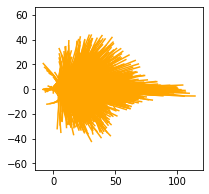

2206

In [18]:
import matplotlib.pyplot as plt

def PlotGeneratedTrajectories(future_list):
  plt.figure(figsize=(3, 3))

  for future in future_list:
    plt.plot(future[:, 1], -future[:, 0], c='orange')

  # Keep aspect ratio of axis
  plt.axis('equal')
  plt.show()

PlotGeneratedTrajectories(trajectories_set)
len(trajectories_set)

Wandb config

In [49]:
import wandb

wandb.init(
    project='CoverNet',
    entity='techtoker',
    config={    
        "epoch": 30,
        "batch_size": 32,
        # Trajectory set 8: 64 ;Trajectory set 2 : 2206
        "num_modes": 2206,
        "lr":5e-4
    })

config = wandb.config

Dataset

In [50]:
from torch.utils.data import DataLoader, Dataset

import numpy as np
from typing import List

class NuscenesDataset(Dataset):
    def __init__(self, features: List[str], states: List[str], labels: List[str]):
        self.features = features
        self.states = states
        self.labels = labels

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index: int):

        image = self.features[index].reshape((500, 500, 3))
        image = torch.Tensor(image).permute(2, 0, 1)
        
        agent_state_vector = torch.Tensor(self.states[index])
        ground_truth = self.labels[index].reshape((12, 2))

        # Convert to [batch_size, 1, 12, 2]
        # Because loss function need that format
        ground_truth = np.expand_dims(ground_truth, 0)

        return image, agent_state_vector, ground_truth

In [51]:
train_ds = NuscenesDataset(train_features, train_states, train_labels)
train_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)

train_val_ds = NuscenesDataset(validation_features, validation_states, validation_labels)
train_val_dl = DataLoader(train_ds, batch_size=config.batch_size * 2)

In [52]:
image, state, ground_truth = next(iter(train_dl))
print(image.size())
print(state.size())
print(ground_truth.size())

print("Preprocessing states:")
print(state)

torch.Size([32, 3, 500, 500])
torch.Size([32, 3])
torch.Size([32, 1, 12, 2])
Preprocessing states:
tensor([[ 1.8005e-02, -1.2057e-02,  0.0000e+00],
        [ 2.5030e+00,  2.1642e+00, -3.5412e-01],
        [ 1.2306e+00, -4.9294e-01,  0.0000e+00],
        [ 7.2228e+00, -5.6059e-01,  1.6059e-01],
        [ 1.2138e+01, -1.0654e+00,  0.0000e+00],
        [ 1.1572e+00,  1.5678e-01, -1.5703e-01],
        [ 2.6336e+00,  8.3544e-03, -9.2898e-02],
        [ 9.8670e+00,  1.2365e+00, -4.8883e-02],
        [ 1.0921e-01,  1.6834e-01,  0.0000e+00],
        [ 3.0062e+00,  1.4489e+00, -4.1705e-01],
        [ 4.5417e+00,  8.0604e-01, -3.4988e-02],
        [ 1.3299e+00,  1.9357e-04, -2.1207e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 6.5436e+00, -3.1180e-02,  0.0000e+00],
        [ 4.5856e-02,  7.3952e-03,  0.0000e+00],
        [ 8.4260e+00, -2.0822e-02,  0.0000e+00],
        [ 3.7300e+00, -3.6697e-01, -2.4005e-02],
        [ 1.6054e+00,  7.1596e-02,  6.9753e-02],
        [ 1.4018e+0

In [53]:
# Build-in backbone ResNet
#from nuscenes.prediction.models.backbone import ResNetBackbone

# Torchvision ResNet
#import torchvision.models as models

# RepVGG
from repVgg.repVggBackbone import RepVGGBackbone

# Torchvision backbone
# backbone = models.resnext50_32x4d(pretrained=True)

# Build-in backbone
#backbone = ResNetBackbone('resnet50')

# RepVGG

backbone = RepVGGBackbone()

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =

In [54]:
# Reshape last layer as 2048 (not 1000)
import torch.nn as nn

backbone.linear = nn.Linear(in_features=1280, out_features=2048, bias=True)
print(backbone)

RepVGGBackbone(
  (backbone): RepVGG(
    (stage0): RepVGGBlock(
      (nonlinearity): ReLU()
      (se): Identity()
      (rbr_dense): Sequential(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (rbr_1x1): Sequential(
        (conv): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stage1): Sequential(
      (0): RepVGGBlock(
        (nonlinearity): ReLU()
        (se): Identity()
        (rbr_dense): Sequential(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (rbr_1x1): Sequential(
          (conv): Conv2d(48, 48, kernel_size=(1, 1), stride=(2, 2), bia

In [55]:
# # Set backbone to non-trainable
# def set_parameter_requires_grad(model):
#     for param in model.parameters():
#         param.requires_grad = False
        
# set_parameter_requires_grad(backbone)

In [56]:
from torch.optim import SGD
from nuscenes.prediction.models.covernet import CoverNet, ConstantLatticeLoss

model = CoverNet(backbone, num_modes=config.num_modes)
model = model.to(device)

loss_function = ConstantLatticeLoss(trajectories_set)

In [57]:
print(config.num_modes)

2206


In [58]:
# Pass to optimizer only params with requires_grad
params_to_update = []

for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = SGD(params_to_update, lr=config.lr, momentum=0.9, weight_decay=5e-4)

	 backbone.backbone.stage0.rbr_dense.conv.weight
	 backbone.backbone.stage0.rbr_dense.bn.weight
	 backbone.backbone.stage0.rbr_dense.bn.bias
	 backbone.backbone.stage0.rbr_1x1.conv.weight
	 backbone.backbone.stage0.rbr_1x1.bn.weight
	 backbone.backbone.stage0.rbr_1x1.bn.bias
	 backbone.backbone.stage1.0.rbr_dense.conv.weight
	 backbone.backbone.stage1.0.rbr_dense.bn.weight
	 backbone.backbone.stage1.0.rbr_dense.bn.bias
	 backbone.backbone.stage1.0.rbr_1x1.conv.weight
	 backbone.backbone.stage1.0.rbr_1x1.bn.weight
	 backbone.backbone.stage1.0.rbr_1x1.bn.bias
	 backbone.backbone.stage1.1.rbr_identity.weight
	 backbone.backbone.stage1.1.rbr_identity.bias
	 backbone.backbone.stage1.1.rbr_dense.conv.weight
	 backbone.backbone.stage1.1.rbr_dense.bn.weight
	 backbone.backbone.stage1.1.rbr_dense.bn.bias
	 backbone.backbone.stage1.1.rbr_1x1.conv.weight
	 backbone.backbone.stage1.1.rbr_1x1.bn.weight
	 backbone.backbone.stage1.1.rbr_1x1.bn.bias
	 backbone.backbone.stage2.0.rbr_dense.conv.weight
	

In [59]:
import copy

current_epoch = 0
best_model_wts = copy.deepcopy(model.state_dict())

In [61]:
from tqdm import tqdm
import time

def loss_batch(model, loss_func, img, state_vec, ground_truth, opt=None):
    img = img.to(device)
    state_vec = state_vec.to(device)
    ground_truth = ground_truth.to(device)
    
    predicted_logits = model(img, state_vec)
    loss = loss_func(predicted_logits, ground_truth)

    # For validation optimizer is None, thus we dont perform backprop
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    # Return losses and amount of items
    #print(f"{loss.item()}; {len(img)}")
    return loss.item(), len(img)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    global current_epoch
    global best_model_wts
    
    best_loss = 999.0

    for epoch in range(epochs):
        start_epoch_time = time.time()
        print('-' * 20)
        print(f'Epoch: {epoch + 1}/{epochs}')
        
        model.train()
        
        losses = []
        nums = []
        for img, state_vec, gt in tqdm(train_dl):
            loss, num = loss_batch(model, loss_func, img, state_vec, gt, opt)
            losses.append(loss)
            nums.append(num)

        # Calculate train loss
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            
        model.eval()
        print("Validation step")

        with torch.no_grad():
            losses = []
            nums = []
            for img, state_vec, gt in tqdm(valid_dl):
                loss, num = loss_batch(model, loss_func, img, state_vec, gt)
                losses.append(loss)
                nums.append(num)

        # Calculate validation loss
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        # deep copy the model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        wandb.log({'Train loss': train_loss, 'Val loss': val_loss})    
        
        print(f"Epoch {current_epoch + 1}; Train loss: {train_loss:0.2f}; Val loss: {val_loss:0.2f}; Best VL: {best_loss:0.2f}; Time: {(time.time() - start_epoch_time):0.2f} sec;")
        torch.save(copy.deepcopy(model.state_dict()), f'./VGG_CoverNet_e{current_epoch + 1}_{best_loss:0.2f}.pth')
        current_epoch += 1
        

In [62]:
current_epoch = 0
fit(config.epoch, model, loss_function, optimizer, train_dl, train_val_dl)

--------------------
Epoch: 1/30


100%|██████████| 157/157 [01:15<00:00,  2.08it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.42it/s]


Epoch 1; Train loss: 5.86; Val loss: 5.04; Best VL: 5.04; Time: 108.33 sec;
--------------------
Epoch: 2/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 2; Train loss: 4.94; Val loss: 4.52; Best VL: 4.52; Time: 108.53 sec;
--------------------
Epoch: 3/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 3; Train loss: 4.47; Val loss: 4.04; Best VL: 4.04; Time: 108.57 sec;
--------------------
Epoch: 4/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 4; Train loss: 4.08; Val loss: 3.63; Best VL: 3.63; Time: 108.71 sec;
--------------------
Epoch: 5/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 5; Train loss: 3.71; Val loss: 3.31; Best VL: 3.31; Time: 108.57 sec;
--------------------
Epoch: 6/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 6; Train loss: 3.40; Val loss: 2.97; Best VL: 2.97; Time: 108.64 sec;
--------------------
Epoch: 7/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 7; Train loss: 3.07; Val loss: 2.86; Best VL: 2.86; Time: 108.81 sec;
--------------------
Epoch: 8/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 8; Train loss: 2.83; Val loss: 2.37; Best VL: 2.37; Time: 108.78 sec;
--------------------
Epoch: 9/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 9; Train loss: 2.53; Val loss: 2.07; Best VL: 2.07; Time: 108.68 sec;
--------------------
Epoch: 10/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 10; Train loss: 2.26; Val loss: 1.83; Best VL: 1.83; Time: 108.70 sec;
--------------------
Epoch: 11/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:33<00:00,  2.39it/s]


Epoch 11; Train loss: 2.01; Val loss: 1.58; Best VL: 1.58; Time: 108.97 sec;
--------------------
Epoch: 12/30


100%|██████████| 157/157 [01:16<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 12; Train loss: 1.77; Val loss: 1.37; Best VL: 1.37; Time: 108.92 sec;
--------------------
Epoch: 13/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 13; Train loss: 1.54; Val loss: 1.14; Best VL: 1.14; Time: 108.73 sec;
--------------------
Epoch: 14/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 14; Train loss: 1.31; Val loss: 0.94; Best VL: 0.94; Time: 108.90 sec;
--------------------
Epoch: 15/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 15; Train loss: 1.12; Val loss: 0.76; Best VL: 0.76; Time: 108.81 sec;
--------------------
Epoch: 16/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 16; Train loss: 0.94; Val loss: 0.73; Best VL: 0.73; Time: 108.69 sec;
--------------------
Epoch: 17/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 17; Train loss: 0.77; Val loss: 0.55; Best VL: 0.55; Time: 108.76 sec;
--------------------
Epoch: 18/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 18; Train loss: 0.65; Val loss: 0.37; Best VL: 0.37; Time: 108.92 sec;
--------------------
Epoch: 19/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 19; Train loss: 0.52; Val loss: 0.35; Best VL: 0.35; Time: 108.65 sec;
--------------------
Epoch: 20/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 20; Train loss: 0.42; Val loss: 0.22; Best VL: 0.22; Time: 108.66 sec;
--------------------
Epoch: 21/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 21; Train loss: 0.33; Val loss: 0.18; Best VL: 0.18; Time: 108.64 sec;
--------------------
Epoch: 22/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:33<00:00,  2.39it/s]


Epoch 22; Train loss: 0.27; Val loss: 0.12; Best VL: 0.12; Time: 109.07 sec;
--------------------
Epoch: 23/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 23; Train loss: 0.21; Val loss: 0.10; Best VL: 0.10; Time: 108.50 sec;
--------------------
Epoch: 24/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 24; Train loss: 0.17; Val loss: 0.08; Best VL: 0.08; Time: 108.71 sec;
--------------------
Epoch: 25/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 25; Train loss: 0.17; Val loss: 0.08; Best VL: 0.08; Time: 108.76 sec;
--------------------
Epoch: 26/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 26; Train loss: 0.15; Val loss: 0.08; Best VL: 0.08; Time: 108.64 sec;
--------------------
Epoch: 27/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 27; Train loss: 0.11; Val loss: 0.06; Best VL: 0.06; Time: 108.82 sec;
--------------------
Epoch: 28/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.42it/s]


Epoch 28; Train loss: 0.11; Val loss: 0.05; Best VL: 0.05; Time: 108.40 sec;
--------------------
Epoch: 29/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 29; Train loss: 0.08; Val loss: 0.04; Best VL: 0.04; Time: 108.87 sec;
--------------------
Epoch: 30/30


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


Epoch 30; Train loss: 0.09; Val loss: 0.03; Best VL: 0.03; Time: 108.59 sec;


In [63]:
fit(5, model, loss_function, optimizer, train_dl, train_val_dl)

--------------------
Epoch: 1/5


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 31; Train loss: 0.06; Val loss: 0.02; Best VL: 0.02; Time: 108.84 sec;
--------------------
Epoch: 2/5


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 32; Train loss: 0.05; Val loss: 0.02; Best VL: 0.02; Time: 108.69 sec;
--------------------
Epoch: 3/5


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:33<00:00,  2.38it/s]


Epoch 33; Train loss: 0.04; Val loss: 0.02; Best VL: 0.02; Time: 109.04 sec;
--------------------
Epoch: 4/5


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.39it/s]


Epoch 34; Train loss: 0.05; Val loss: 0.02; Best VL: 0.02; Time: 109.00 sec;
--------------------
Epoch: 5/5


100%|██████████| 157/157 [01:15<00:00,  2.07it/s]


Validation step


100%|██████████| 79/79 [00:32<00:00,  2.39it/s]


Epoch 35; Train loss: 0.04; Val loss: 0.02; Best VL: 0.02; Time: 108.90 sec;


In [ ]:
fit(5, model, loss_function, optimizer, train_dl, train_val_dl)

--------------------
Epoch: 1/5


  8%|▊         | 13/157 [00:06<01:09,  2.06it/s]

In [ ]:
# Mark the run as finished
wandb.finish()

In [25]:
torch.save(model.state_dict(), f'./VGG_CoverNet_e5.pth')

In [33]:
# from repVgg.repvgg import repvgg_model_convert, create_RepVGG_A0
# backbone.backbone = repvgg_model_convert(backbone.backbone, save_path='./repVgg/Models/RepVGG-A0-deploy.pth')

### Metrics

In [34]:
model.load_state_dict(torch.load('./Models/VGG_5k_e20_1-13.pth'))

for module in model.modules():
    if hasattr(module, 'switch_to_deploy'):
        module.switch_to_deploy()

model.eval()

CoverNet(
  (backbone): RepVGGBackbone(
    (backbone): RepVGG(
      (stage0): RepVGGBlock(
        (nonlinearity): ReLU()
        (se): Identity()
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (stage1): Sequential(
        (0): RepVGGBlock(
          (nonlinearity): ReLU()
          (se): Identity()
          (rbr_reparam): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        )
        (1): RepVGGBlock(
          (nonlinearity): ReLU()
          (se): Identity()
          (rbr_reparam): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (stage2): Sequential(
        (0): RepVGGBlock(
          (nonlinearity): ReLU()
          (se): Identity()
          (rbr_reparam): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        )
        (1): RepVGGBlock(
          (nonlinearity): ReLU()
          (se): Identity()
          (rbr_reparam): Conv2d(96, 96, kern

In [8]:
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.splits import get_prediction_challenge_split

# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = 'Dataset/'

history_length = 2
prediction_length = 6

# Use v1.0-trainval or v1.0-mini
nusc = NuScenes('v1.0-trainval', dataroot=DATAROOT, verbose=False)
helper = PredictHelper(nusc)

In [9]:
test = get_prediction_challenge_split("val", dataroot=DATAROOT)
test = test[:5000]

In [10]:
import numpy as np

test_features = np.load(f'{CURRENT_PATH}test_features_5k.npy')
test_states = np.load(f'{CURRENT_PATH}test_states_5k.npy')
test_labels = np.load(f'{CURRENT_PATH}test_labels_5k.npy')

In [35]:
import nuscenes.eval.prediction.metrics as metrics

trajectories_set_8_np = trajectories_set_8.numpy()

metric_functions = [metrics.MinFDEK([1], aggregators=[metrics.RowMean()]),
                    metrics.MinADEK([5, 10], aggregators=[metrics.RowMean()]),
                    metrics.MissRateTopK([5, 10], tolerance=2, aggregators=[metrics.RowMean()])]

num_predictions = len(test_labels) # Amount of prediction rows

metrics_container = {metric.name: np.zeros((num_predictions, metric.shape)) for metric in metric_functions}
metrics_container

{'MinFDEK': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]),
 'MinADEK': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 'MissRateTopK_2': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])}

In [36]:
from tqdm import tqdm

for idx, x in enumerate(tqdm(test_labels)):
#for idx in range(len(test_labels)):
    # Make prediction
    img = torch.Tensor(test_features[idx].reshape((500, 500, 3))).permute(2, 0, 1).unsqueeze(0)
    img = img.to(device)

    state = torch.Tensor(np.array([test_states[idx]])).to(device)
    state = state.to(device)

    logits = model(img, state)
    mode_probabilities = np.array([logits.cpu().detach().numpy()[0]])[0]

    # Create prediction object
    instance_tkn, sample_tkn = test[idx].split("_")
    prediction = metrics.Prediction(instance_tkn, sample_tkn, trajectories_set_8_np, mode_probabilities)

    # Get ground_truth
    gt = test_labels[idx].reshape((12, 2))

    # Calculate metrics
    for metric in metric_functions:
        metrics_container[metric.name][idx] = metric(gt, prediction)

100%|██████████| 5000/5000 [01:54<00:00, 43.68it/s]


In [37]:
from collections import defaultdict
from typing import List, Dict, Any

aggregations: Dict[str, Dict[str, List[float]]] = defaultdict(dict)

for metric in metric_functions:
    for agg in metric.aggregators:
        aggregations[metric.name][agg.name] = agg(metrics_container[metric.name])

aggregations


defaultdict(dict,
            {'MinFDEK': {'RowMean': [13.618132816253471]},
             'MinADEK': {'RowMean': [3.096267418084196, 2.5359863287850084]},
             'MissRateTopK_2': {'RowMean': [0.9418, 0.926]}})

In [32]:
from collections import defaultdict
from typing import List, Dict, Any

aggregations: Dict[str, Dict[str, List[float]]] = defaultdict(dict)

for metric in metric_functions:
    for agg in metric.aggregators:
        aggregations[metric.name][agg.name] = agg(metrics_container[metric.name])

aggregations

defaultdict(dict,
            {'MinFDEK': {'RowMean': [12.69734865573583]},
             'MinADEK': {'RowMean': [2.8673411186545716, 2.356200444074625]},
             'MissRateTopK_2': {'RowMean': [0.9238, 0.9198]}})

In [45]:
from collections import defaultdict
from typing import List, Dict, Any

aggregations: Dict[str, Dict[str, List[float]]] = defaultdict(dict)

for metric in metric_functions:
    for agg in metric.aggregators:
        aggregations[metric.name][agg.name] = agg(metrics_container[metric.name])

aggregations

defaultdict(dict,
            {'MinFDEK': {'RowMean': [14.253963928187535]},
             'MinADEK': {'RowMean': [3.244872547541568, 2.5645119673191026]},
             'MissRateTopK_2': {'RowMean': [0.9396, 0.9338]}})

In [37]:
torch.save(model.state_dict(), '/root/model.pth')

In [21]:
import shutil

shutil.rmtree('/root/Dataset', ignore_errors=True)